# CNN + Machine Learning Classification for Keypoint Dataset

In [57]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch

In [58]:
# Load และเตรียมข้อมูล
df = pd.read_csv(r"D:\git_project\workshop_lifting\app\Train\Labeled_Dataset__English_.csv")

In [59]:
df_drop_unknown = df[df["label"] != "unknown"]
df_lift = df_drop_unknown[df_drop_unknown['label'] != "lift"]
df_place = df_lift[df_lift['label'] != "place"]
df_place['label'].unique()

array(['hold', 'empty'], dtype=object)

In [62]:
X = df_place.drop(columns=["time", "label"]).values
y = df_place["label"].values

In [63]:
# สร้าง window ขนาด 30 frame (เช่น 1 วิ)
window_size = 30
stride = 15

X_windows, y_windows = [], []

for start in range(0, len(X) - window_size, stride):
    end = start + window_size
    if len(set(y[start:end])) == 1:  # เอาเฉพาะช่วงที่ label เดียวกัน
        X_windows.append(X[start:end])
        y_windows.append(y[start])

X_windows = np.array(X_windows)  # shape: [N, 30, features]
y_windows = np.array(y_windows)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_encoded, test_size=0.2, random_state=42)

# PyTorch Dataset
class KeypointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = KeypointDataset(X_train, y_train)
test_dataset = KeypointDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [64]:

import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 6, 128)  # ปรับตาม input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, features, time]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = CNNClassifier(num_features=X.shape[1], num_classes=len(label_encoder.classes_))


In [65]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(300):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()


In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# รายงานผล
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Matrix ความสับสน
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

       empty       0.69      1.00      0.81        11
        hold       1.00      0.69      0.81        16

    accuracy                           0.81        27
   macro avg       0.84      0.84      0.81        27
weighted avg       0.87      0.81      0.81        27

Confusion Matrix:
[[11  0]
 [ 5 11]]


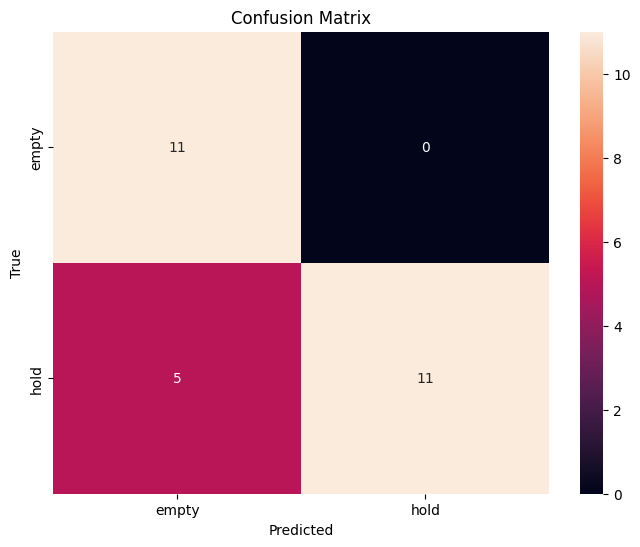

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [69]:
import cv2
import mediapipe as mp

In [71]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def pred_in_video(video_file):
    if video_file:
        cap = cv2.VideoCapture(video_file)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        
        # temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".mp4")
        # out_file = temp_file.name  # Get temp file path

        # out = cv2.VideoWriter(
        #                     out_file,
        #                     cv2.VideoWriter_fourcc(*"mp4v"),
        #                     fps,
        #                     (frame_width, frame_height)
        #                     )

        data_dict = {'time':[]}
        frame_number = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # timestamp = frame_number / fps
            frame_number += 1

            # Convert frame to RGB (MediaPipe requires RGB input)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Process frame
            results = pose.process(rgb_frame)
            
            # Draw landmarks and Record if detected
            if results.pose_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(frame, 
                                                          results.pose_landmarks, 
                                                          mp_pose.POSE_CONNECTIONS)
                result_landmark = results.pose_landmarks.landmark

                data_dict['time'].append(frame_number / fps)
                
                for i in range(len(result_landmark)):
                    column_x = f'keypoint_{i}_x'
                    column_y = f'keypoint_{i}_y'
                    column_z = f'keypoint_{i}_z'
                    column_vi = f'keypoint_{i}_visibility'

                    if column_x not in data_dict:
                        data_dict[column_x] = []
                        data_dict[column_y] = []
                        data_dict[column_z] = []
                        data_dict[column_vi] = []
                    
                    # data_dict['time'].append(frame_number / fps)
                    data_dict[column_x].append(result_landmark[i].x)
                    data_dict[column_y].append(result_landmark[i].y)
                    data_dict[column_z].append(result_landmark[i].z)
                    data_dict[column_vi].append(result_landmark[i].visibility)

            # Save frame to output video
            # out.write(frame)

    cap.release()
    # out.release()

    df = pd.DataFrame(data_dict)
    # converted_file = out_file.replace(".mp4", "_converted.mp4")
    # convert_to_h264(out_file, converted_file)

    # time.sleep(1)

    return df

In [ ]:
model()

In [ ]:
import pandas as pd
import math

# -------------------------------------------------------------------
# 1. Velocity Computation
# -------------------------------------------------------------------
def compute_velocity(prev_row, current_row):
    """
    Compute the scalar velocity (magnitude) of the wrist between two consecutive rows.
    prev_row and current_row are Pandas Series or dictionaries with keys: x, y, z, time
    """
    dx = current_row['x'] - prev_row['x']
    dy = current_row['y'] - prev_row['y']
    dz = current_row['z'] - prev_row['z']
    
    dist = math.sqrt(dx**2 + dy**2 + dz**2)
    
    dt = current_row['time'] - prev_row['time']
    if dt == 0:
        # Avoid divide-by-zero; handle as velocity = 0 if times are the same
        return 0.0
    
    vel = dist / dt
    return vel


# -------------------------------------------------------------------
# 2. Finite-State Machine Definition
# -------------------------------------------------------------------
class PickPlaceStateMachine:
    
    def __init__(self,
                 vel_min=0.02,           # threshold for "near zero" velocity
                 pick_angle_min=0,       # minimal pitch angle for picking
                 pick_angle_max=20,      # maximal pitch angle for picking
                 place_angle_min=15,     # minimal pitch angle for placing
                 place_angle_max=30):    # maximal pitch angle for placing
        
        self.vel_min = vel_min
        self.pick_angle_min = pick_angle_min
        self.pick_angle_max = pick_angle_max
        self.place_angle_min = place_angle_min
        self.place_angle_max = place_angle_max
        
        # Possible states
        self.state_list = ["IDLE", "APPROACH", "GRASP", "TRANSPORT", "PLACE"]
        self.current_state = "IDLE"
    
    def update_state(self, velocity, pitch):
        """
        Update the FSM based on velocity + pitch.
        Return the current state.
        """
        # IDLE
        if self.current_state == "IDLE":
            if (self.pick_angle_min <= pitch <= self.pick_angle_max) and (velocity > self.vel_min):
                self.current_state = "APPROACH"

        # APPROACH
        elif self.current_state == "APPROACH":
            if (velocity < self.vel_min) and (self.pick_angle_min <= pitch <= self.pick_angle_max):
                self.current_state = "GRASP"
            elif not (self.pick_angle_min <= pitch <= self.pick_angle_max):
                self.current_state = "IDLE"

        # GRASP
        elif self.current_state == "GRASP":
            if velocity > self.vel_min:
                self.current_state = "TRANSPORT"
            elif not (self.pick_angle_min <= pitch <= self.pick_angle_max):
                self.current_state = "IDLE"

        # TRANSPORT
        elif self.current_state == "TRANSPORT":
            if (velocity < self.vel_min) and (self.place_angle_min <= pitch <= self.place_angle_max):
                self.current_state = "PLACE"
            elif (velocity < self.vel_min):
                self.current_state = "IDLE"

        # PLACE
        elif self.current_state == "PLACE":
            if velocity < self.vel_min:
                self.current_state = "IDLE"
        
        return self.current_state

# -------------------------------------------------------------------
# 3. Main Routine: Reading CSV & Applying FSM
# -------------------------------------------------------------------
def main():
    # STEP 1: Read CSV
    # Replace "time", "x", "y", "z", "pitch" with your actual column names
    df = pd.read_csv("D:\git_project\workshop_lifting\dataset_test.csv")
    
    df.rename(columns={
    'Time': 'time',
    'X': 'x',
    'Y': 'y',
    'Z': 'z',
    'HandPitch': 'pitch'
}, inplace=True)

    # Ensure data is sorted by time if not already
    df.sort_values(by='time', inplace=True, ignore_index=True)
    
    # STEP 2: Initialize FSM
    fsm = PickPlaceStateMachine(
        vel_min=0.02,           # Adjust as appropriate
        pick_angle_min=0,       # Example range for picking
        pick_angle_max=20,
        place_angle_min=15,     # Example range for placing
        place_angle_max=30
    )

    # STEP 3: Calculate velocity and update FSM for each row
    velocities = []
    states = []

    for i in range(len(df)):
        if i == 0:
            velocity = 0.0
        else:
            velocity = compute_velocity(df.iloc[i-1], df.iloc[i])
        
        current_pitch = df.iloc[i]['pitch']
        
        # Update the state machine
        current_state = fsm.update_state(velocity, current_pitch)

        velocities.append(velocity)
        states.append(current_state)
    
    # STEP 4: Save results back to DataFrame
    df['velocity'] = velocities
    df['state'] = states
    
    # STEP 5: (Optional) Export or display results
    # Print the first few rows
    print(df.head(10))

    # If you want to export the results:
    # df.to_csv("/mnt/data/dataset_test_output.csv", index=False)
    
if __name__ == "__main__":
    main()


KeyError: 'pitch'

In [75]:
import cv2
import mediapipe as mp
import numpy as np

# Mediapipe Pose setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# For drawing: define some colors
GRID_COLOR = (0, 255, 0)   # Green for grid lines
TEXT_COLOR = (0, 0, 255)   # Red for text


In [74]:
def euclidean_distance(p1, p2):
    """Compute Euclidean distance between two points p1=(x1,y1) and p2=(x2,y2)."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [ ]:
def main():
    cap = cv2.VideoCapture("")  # or your video path
    with mp_pose.Pose(static_image_mode=False, 
                      model_complexity=1,
                      enable_segmentation=False,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5) as pose:
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert BGR to RGB for Mediapipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)
            
            # If pose landmarks are detected
            if results.pose_landmarks:
                # Get landmark array
                h, w, _ = frame.shape
                landmarks = results.pose_landmarks.landmark
                
                # Extract relevant landmarks (in normalized coords [0..1])
                # For right foot:
                r_heel  = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value]
                r_index = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value]
                # For left foot:
                l_heel  = landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value]
                l_index = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value]
                
                # Convert normalized coords to pixel coords
                r_heel_xy  = (r_heel.x  * w, r_heel.y  * h)
                r_index_xy = (r_index.x * w, r_index.y * h)
                l_heel_xy  = (l_heel.x  * w, l_heel.y  * h)
                l_index_xy = (l_index.x * w, l_index.y * h)
                
                # Decide which foot to use (the one with the largest heel-index distance).
                # (User requested "longest distance between feet heel and index")
                dist_r = euclidean_distance(r_heel_xy, r_index_xy)
                dist_l = euclidean_distance(l_heel_xy, l_index_xy)
                
                if dist_r >= dist_l:
                    foot_heel_xy  = r_heel_xy
                    foot_index_xy = r_index_xy
                    side_used = 'right'
                else:
                    foot_heel_xy  = l_heel_xy
                    foot_index_xy = l_index_xy
                    side_used = 'left'
                
                # dis_hi = distance in the X-axis only (the user’s definition suggests
                # columns rely on x-distance). If you need pure Euclidean, adapt accordingly.
                dis_hi = abs(foot_heel_xy[0] - foot_index_xy[0])
                
                # We also need y-coordinates for feet, knee, hip, shoulder
                # For the same side or for an average? For clarity, let's use the same side as chosen above.
                if side_used == 'right':
                    foot_xy    = ((foot_heel_xy[0] + foot_index_xy[0]) / 2, 
                                  (foot_heel_xy[1] + foot_index_xy[1]) / 2)
                    knee       = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]
                    hip        = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
                    shoulder   = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
                else:
                    foot_xy    = ((foot_heel_xy[0] + foot_index_xy[0]) / 2, 
                                  (foot_heel_xy[1] + foot_index_xy[1]) / 2)
                    knee       = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
                    hip        = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
                    shoulder   = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
                
                knee_xy     = (knee.x * w, knee.y * h)
                hip_xy      = (hip.x  * w, hip.y  * h)
                shoulder_xy = (shoulder.x * w, shoulder.y * h)
                
                # Prepare row boundaries (from bottom to top in image coordinates):
                y_feet     = foot_xy[1]
                y_knee     = knee_xy[1]
                y_hip      = hip_xy[1]
                y_shoulder = shoulder_xy[1]
                
                # Because in most images, foot is at a larger y-value than the shoulder, we can define:
                # row1: y in [y_knee, y_feet]
                # row2: y in [y_hip,  y_knee]
                # row3: y in [y_shoulder, y_hip]
                # row4: y < y_shoulder
                #
                # If your image or coordinate system is reversed, adjust accordingly.

                # Columns: define x-coordinates
                # first_col_start  = foot_index_xy[0] + dis_hi
                # second_col_start = first_col_start + dis_hi
                #
                # But your text says:
                #   first column -> start at x value of foot index + dis_hi
                #   second column -> start at x value of first column + dis_hi
                #   last column -> everything beyond that
                #
                # We'll define them carefully. We also check if the hand is on the right or left to interpret direction.

                foot_index_x = foot_index_xy[0]
                
                if side_used == 'right':
                    # Typically, if the foot index is to the left of the heel for a right foot,
                    # we define columns going to the right. So:
                    first_col_x  = foot_index_x + dis_hi
                    second_col_x = first_col_x + dis_hi
                    # last column is > second_col_x
                else:
                    # If it's the left side, we might invert the logic (mirroring).
                    # E.g., we define columns going to the left from foot_index_x.
                    first_col_x  = foot_index_x - dis_hi
                    second_col_x = first_col_x - dis_hi
                
                # For demonstration, let's also get the right wrist or left wrist to see where it is
                right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value]
                left_wrist  = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
                
                # We'll check which wrist to track. Suppose we track the *same side* wrist:
                if side_used == 'right':
                    wrist_xy = (right_wrist.x * w, right_wrist.y * h)
                else:
                    wrist_xy = (left_wrist.x * w, left_wrist.y * h)
                
                # -----------
                # Determine which row the wrist is in:
                # -----------
                wx, wy = wrist_xy
                
                # We'll define a small helper:
                def get_row_name(y_val):
                    # We assume y_feet > y_knee > y_hip > y_shoulder in typical camera orientation
                    if y_val >= y_knee:
                        return 1  # row1
                    elif y_hip <= y_val < y_knee:
                        return 2  # row2
                    elif y_shoulder <= y_val < y_hip:
                        return 3  # row3
                    else:
                        return 4  # row4 (above shoulder)
                
                row_id = get_row_name(wy)
                
                # -----------
                # Determine which column the wrist is in:
                # -----------
                def get_col_name(x_val):
                    if side_used == 'right':
                        if x_val < first_col_x:
                            return 0  # "before first column" if the wrist is too close
                        elif first_col_x <= x_val < second_col_x:
                            return 1  # first column
                        else:
                            return 2  # second column or beyond
                    else:
                        # For the left side, we reversed the logic
                        if x_val > first_col_x:
                            return 0  # "before" in the mirrored sense
                        elif second_col_x < x_val <= first_col_x:
                            return 1  # first column
                        else:
                            return 2  # second column or beyond
                
                col_id = get_col_name(wx)
                
                # -----------
                # Draw the grid lines
                # -----------
                # Draw horizontal lines (rows)
                # row1 boundary => y_knee
                # row2 boundary => y_hip
                # row3 boundary => y_shoulder
                cv2.line(frame, (0, int(y_knee)), (w, int(y_knee)), GRID_COLOR, 2)
                cv2.line(frame, (0, int(y_hip)), (w, int(y_hip)), GRID_COLOR, 2)
                cv2.line(frame, (0, int(y_shoulder)), (w, int(y_shoulder)), GRID_COLOR, 2)
                
                # Draw vertical lines (columns) based on side
                # first_col_x, second_col_x
                cv2.line(frame, (int(first_col_x), 0), (int(first_col_x), h), GRID_COLOR, 2)
                cv2.line(frame, (int(second_col_x), 0), (int(second_col_x), h), GRID_COLOR, 2)
                
                # -----------
                # Display the area info
                # -----------
                text_position = (int(wx), int(wy) - 10)
                area_text = f"Row={row_id}, Col={col_id}"
                cv2.putText(frame, area_text, text_position, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, TEXT_COLOR, 2, cv2.LINE_AA)
                
                # Optionally draw a small circle at the wrist
                cv2.circle(frame, (int(wx), int(wy)), 8, (255, 0, 0), -1)
            
            cv2.imshow('Grid Demo', frame)
            if cv2.waitKey(1) & 0xFF == 27:  # ESC to exit
                break
        
        cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Example video path
video_path = r"D:\Dataset\AI_W2_healthcare\lifting_0215.mp4"

cap = cv2.VideoCapture(video_path)
with mp_pose.Pose(min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # Draw pose landmarks for visualization
            mp_drawing.draw_landmarks(frame,
                                      results.pose_landmarks,
                                      mp_pose.POSE_CONNECTIONS)
            
            # Get image dimensions
            h, w, c = frame.shape
            
            # Helper function to get pixel coords of a specific landmark
            def get_landmark(landmark_enum):
                lm = results.pose_landmarks.landmark[landmark_enum]
                return int(lm.x * w), int(lm.y * h)
            
            # Grab right-side landmarks (you can adapt for left side as needed)
            r_foot_index = get_landmark(mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            r_heel       = get_landmark(mp_pose.PoseLandmark.RIGHT_HEEL)
            r_knee       = get_landmark(mp_pose.PoseLandmark.RIGHT_KNEE)
            r_hip        = get_landmark(mp_pose.PoseLandmark.RIGHT_HIP)
            r_shoulder   = get_landmark(mp_pose.PoseLandmark.RIGHT_SHOULDER)
            r_wrist      = get_landmark(mp_pose.PoseLandmark.RIGHT_WRIST)
            
            # 1) Compute the distance between foot heel and foot index (x-coords)
            dis_hi = abs(r_foot_index[0] - r_heel[0])
            
            # 2) Define columns using dis_hi:
            #    first column -> starts at x value of foot index + dis_hi
            #    second column -> starts at x value of first column + dis_hi
            #    last column -> everything beyond the second column
            #
            # For illustration, let's assume foot_index.x < heel.x, so we do:
            # col1_x = r_foot_index[0] + dis_hi
            # col2_x = col1_x + dis_hi
            #
            # If the foot index is to the right of the heel, invert the logic. 
            # A quick way is to just define a "base" = min(r_foot_index[0], r_heel[0]).
            
            foot_min_x = min(r_foot_index[0], r_heel[0])
            col1_x = foot_min_x + dis_hi
            col2_x = foot_min_x + 2 * dis_hi
            
            # 3) Define rows:
            #    first row (Row1): from foot up to knee
            #    second row (Row2): from knee up to hip
            #    third row (Row3): from hip up to shoulder
            #    last row (Row4): above the shoulder
            
            # Typically, the foot is the largest y-value (since y grows downward).
            # We'll gather the relevant y-values:

            foot_y     = max(r_foot_index[1], r_heel[1])  # whichever is lower on the image
            knee_y     = r_knee[1]
            hip_y      = r_hip[1]
            shoulder_y = r_shoulder[1]
            
            # For clarity, let's sort these, though typically foot_y > knee_y > hip_y > shoulder_y
            # But in case the detection is slightly off, or the user is in a different pose:
            sorted_rows = sorted([foot_y, knee_y, hip_y, shoulder_y])
            
            # We'll rename them in ascending order (top->bottom)
            # Actually, we want foot at the bottom, so let's do:
            #   row1 boundary = knee_y
            #   row2 boundary = hip_y
            #   row3 boundary = shoulder_y
            #
            # If foot_y is the largest, that’s effectively the “bottom.” 
            # We can do:
            row_knee = knee_y
            row_hip  = hip_y
            row_shoulder = shoulder_y
            
            # 4) Draw the grid lines on the image for visualization
            #    Vertical lines
            cv2.line(frame, (int(col1_x), 0), (int(col1_x), h), (0, 255, 0), 2)
            cv2.line(frame, (int(col2_x), 0), (int(col2_x), h), (0, 255, 0), 2)
            
            #    Horizontal lines
            cv2.line(frame, (0, int(row_knee)), (w, int(row_knee)), (0, 255, 0), 2)
            cv2.line(frame, (0, int(row_hip)), (w, int(row_hip)), (0, 255, 0), 2)
            cv2.line(frame, (0, int(row_shoulder)), (w, int(row_shoulder)), (0, 255, 0), 2)
            
            # 5) Figure out which cell the wrist is in
            wrist_x, wrist_y = r_wrist
            
            #   Columns: 
            if wrist_x < col1_x:
                col_name = "Column 1"
            elif wrist_x < col2_x:
                col_name = "Column 2"
            else:
                col_name = "Column 3"
            
            #   Rows (remember the top of the image is y=0, bottom is y=h):
            #   Row1 (Below Knee)   : y >= row_knee
            #   Row2 (Knee to Hip)  : row_hip <= y < row_knee
            #   Row3 (Hip to Shoulder): row_shoulder <= y < row_hip
            #   Row4 (Above Shoulder): y < row_shoulder
            
            if wrist_y >= row_knee:
                row_name = "Row1 (Foot-Knee)"
            elif row_hip <= wrist_y < row_knee:
                row_name = "Row2 (Knee-Hip)"
            elif row_shoulder <= wrist_y < row_hip:
                row_name = "Row3 (Hip-Shoulder)"
            else:
                row_name = "Row4 (Above Shoulder)"
            
            # 6) If you want to handle “left side” vs. “right side”
            #    (e.g., if the right wrist is actually left of the torso center),
            #    you could do additional checks comparing wrist_x to the torso midpoint.
            #
            #    Example: torso_mid_x = (r_shoulder[0] + l_shoulder[0]) / 2
            #    if wrist_x < torso_mid_x:  # the wrist is on the left side, etc.
            #
            #    For simplicity, we skip that in this snippet.

            # 7) Overlay text on the image showing the wrist's cell
            label_text = f"Wrist in {col_name}, {row_name}"
            cv2.putText(frame, label_text, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 2, cv2.LINE_AA)
        
        # Show the result using OpenCV window (or switch to matplotlib if desired)
        cv2.imshow("Pose Grid", cv2.resize(frame,(800,800)))
        
        if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to exit
            break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Example video path
video_path = r"D:\Dataset\AI_W2_healthcare\lifting_0215.mp4"

cap = cv2.VideoCapture(video_path)
with mp_pose.Pose(min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR to RGB for processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # Draw pose landmarks for visualization
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS
            )

            # Get image dimensions
            h, w, c = frame.shape

            # Helper: convert landmark to pixel coordinates
            def get_landmark(landmark_enum):
                lm = results.pose_landmarks.landmark[landmark_enum]
                return int(lm.x * w), int(lm.y * h)

            # Grab right-side landmarks (adapt if needed for left side)
            r_foot_index = get_landmark(mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            r_heel       = get_landmark(mp_pose.PoseLandmark.RIGHT_HEEL)
            r_knee       = get_landmark(mp_pose.PoseLandmark.RIGHT_KNEE)
            r_hip        = get_landmark(mp_pose.PoseLandmark.RIGHT_HIP)
            r_shoulder   = get_landmark(mp_pose.PoseLandmark.RIGHT_SHOULDER)
            r_wrist      = get_landmark(mp_pose.PoseLandmark.RIGHT_WRIST)

            # 1) Compute horizontal distance between foot heel and foot index
            dis_hi = abs(r_foot_index[0] - r_heel[0])

            # Use the foot index x-coordinate as a reference boundary
            foot_index_x = r_foot_index[0]
            wrist_x, wrist_y = r_wrist

            # 2) Define horizontal grid lines (rows)
            # Get y-coordinates of foot, knee, hip, shoulder.
            # Note: In images, y increases downward.
            foot_y     = max(r_foot_index[1], r_heel[1])  # lower (larger y) of the two
            knee_y     = r_knee[1]
            hip_y      = r_hip[1]
            shoulder_y = r_shoulder[1]
            
            # Sort these y-values (ascending order: top->bottom)
            row_lines = sorted([shoulder_y, hip_y, knee_y, foot_y])
            # Draw horizontal lines across the image
            for y_line in row_lines:
                cv2.line(frame, (0, y_line), (w, y_line), (0, 0, 255), 2)

            # 3) Define vertical grid lines (columns) based on wrist location
            if wrist_x >= foot_index_x:
                # If wrist is on the right side of the foot index,
                # use boundaries: foot_index_x, col1_end, col2_end.
                col1_end = foot_index_x + dis_hi
                col2_end = foot_index_x + 2 * dis_hi
                col_lines = sorted([foot_index_x, int(col1_end), int(col2_end)])
            else:
                # If wrist is on the left side,
                # define: col1_start (to the left of foot_index_x) and col2_end (further left).
                col1_start = foot_index_x - dis_hi
                col2_end = foot_index_x - 2 * dis_hi
                col_lines = sorted([foot_index_x, int(col1_start), int(col2_end)])

            # Draw vertical lines from top to bottom
            for x_line in col_lines:
                cv2.line(frame, (x_line, 0), (x_line, h), (0, 0, 255), 2)

            # Optionally, you can now compute which grid cell the wrist is in.
            # (This part is left as an exercise for further customization.)

            # Overlay text showing wrist coordinates
            label_text = f"Wrist: ({wrist_x}, {wrist_y})"
            cv2.putText(frame, label_text, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2, cv2.LINE_AA)

        # Resize and display the result
        display_frame = cv2.resize(frame, (800, 800))
        cv2.imshow("Pose Grid", display_frame)

        if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to exit
            break

cap.release()
cv2.destroyAllWindows()


In [85]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Video path
video_path = r"D:\Dataset\AI_W2_healthcare\lifting_0215.mp4"
cap = cv2.VideoCapture(video_path)

with mp_pose.Pose(min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR to RGB for processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # Draw the pose landmarks for visualization
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Get image dimensions
            h, w, c = frame.shape

            # Helper function to convert a landmark to pixel coordinates
            def get_landmark(landmark_enum):
                lm = results.pose_landmarks.landmark[landmark_enum]
                return int(lm.x * w), int(lm.y * h)

            # Get right-side landmarks (adapt if needed for left side)
            r_foot_index = get_landmark(mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            r_heel       = get_landmark(mp_pose.PoseLandmark.RIGHT_HEEL)
            r_knee       = get_landmark(mp_pose.PoseLandmark.RIGHT_KNEE)
            r_hip        = get_landmark(mp_pose.PoseLandmark.RIGHT_HIP)
            r_shoulder   = get_landmark(mp_pose.PoseLandmark.RIGHT_SHOULDER)
            r_wrist      = get_landmark(mp_pose.PoseLandmark.RIGHT_WRIST)

            # 1) Compute the horizontal distance between the foot heel and foot index
            dis_hi = abs(r_foot_index[0] - r_heel[0])
            # Use the foot index's x-coordinate as a reference boundary
            foot_index_x = r_foot_index[0]
            wrist_x, wrist_y = r_wrist

            # 2) Define row boundaries using landmark y-coordinates
            # For a standing person, y increases downward.
            # Collect y-coordinates for shoulder, hip, knee, and foot.
            foot_y     = max(r_foot_index[1], r_heel[1])  # Lower of the two (largest y)
            knee_y     = r_knee[1]
            hip_y      = r_hip[1]
            shoulder_y = r_shoulder[1]
            # Sort from top (smallest y) to bottom (largest y)
            row_lines = sorted([shoulder_y, hip_y, knee_y, foot_y])
            
            # Draw horizontal grid lines (across the full width)
            for y_line in row_lines:
                cv2.line(frame, (0, y_line), (w, y_line), (0, 0, 255), 2)

            # Determine in which row the wrist is located:
            # sorted order: row_lines[0] (shoulder), row_lines[1] (hip), row_lines[2] (knee), row_lines[3] (foot)
            if wrist_y >= row_lines[2]:
                row_num = 1  # between knee and foot
            elif wrist_y >= row_lines[1]:
                row_num = 2  # between hip and knee
            elif wrist_y >= row_lines[0]:
                row_num = 3  # between shoulder and hip
            else:
                row_num = 4  # above shoulder

            # 3) Define vertical grid boundaries (columns) based on wrist location relative to foot index
            if wrist_x >= foot_index_x:
                # Wrist is on the right side:
                col1_end = foot_index_x + dis_hi
                col2_end = foot_index_x + 2 * dis_hi
                col_lines = sorted([foot_index_x, int(col1_end), int(col2_end)])
                # Determine column for right-side wrist:
                if wrist_x < col1_end:
                    col_num = 1
                elif wrist_x < col2_end:
                    col_num = 2
                else:
                    col_num = 3
            else:
                # Wrist is on the left side:
                col1_start = foot_index_x - dis_hi
                col2_end = foot_index_x - 2 * dis_hi
                col_lines = sorted([foot_index_x, int(col1_start), int(col2_end)])
                # Determine column for left-side wrist:
                if wrist_x >= col1_start:
                    col_num = 1
                elif wrist_x >= col2_end:
                    col_num = 2
                else:
                    col_num = 3

            # Draw vertical grid lines (from top to bottom)
            for x_line in col_lines:
                cv2.line(frame, (x_line, 0), (x_line, h), (0, 0, 255), 2)

            # 4) Overlay the grid cell information on the image
            label_text = f"Wrist in Row {row_num}, Column {col_num}"
            cv2.putText(frame, label_text, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2, cv2.LINE_AA)

        # Resize and display the resulting frame
        display_frame = frame
        cv2.imshow("Pose Grid", cv2.resize(display_frame,(int(w*0.5),int(h*0.5))))
        if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to exit
            break

cap.release()
cv2.destroyAllWindows()
